In [1]:
import sys,os,glob,copy
sys.path.append('../')
import numpy as np
from statistics import median, mean
from numpy.linalg import norm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d, griddata
from itertools import product
import matplotlib as mpl
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown
import glob
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')


pd.set_option('display.max_rows', 200)

### Load Recast Data

In [2]:
# Load models (scalar and pseudoscalar)
inputFiles = ['../CMS-EXO-20-004/scanResults_scalar_pt_nocut.pcl',
              '../CMS-EXO-20-004/scanResults_pseudoscalar_pt_nocut.pcl']
dfs = [pd.read_pickle(i) for i in inputFiles]
recastData = pd.concat(dfs, ignore_index=True)

### Get model points

In [3]:
models = []
mCols = ['Coupling', 'Mode', '$m_{med}$', '$m_{DM}$']
for row in recastData[mCols].values:
    m = dict(zip(mCols, row.tolist()))
    if m not in models:
        models.append(m)

print('%i models loaded.' %len(models))

169 models loaded.


### Get model parameters

In [4]:
parameters = {label : list(set([m[label] for m in models])) for label in mCols}
for k,v in parameters.items():
    if len(v) == 1:
        parameters[k] = v[0]
print(parameters)

textstr = '\n'.join([r'%s = %s' %(k,v) for k,v in parameters.items() if k not in ['$m_{med}$','$m_{DM}$']])
print(textstr)

{'Coupling': ['Pseudoscalar', 'Scalar'], 'Mode': 'DM+QCDjets', '$m_{med}$': [1250.0, 995.0, 100.0, 2500.0, 295.0, 200.0, 1000.0, 10.0, 1995.0, 2250.0, 750.0, 2000.0, 500.0, 1750.0, 3000.0, 250.0, 1500.0, 2750.0], '$m_{DM}$': [1.0, 1000.0, 10.0, 1200.0, 500.0, 150.0, 1400.0]}
Coupling = ['Pseudoscalar', 'Scalar']
Mode = DM+QCDjets


### Obtain Efficiencies

In [5]:
label = [c for c in recastData if (c.startswith("bin_") and not 'Error' in c)]

for l in label:
    ns = recastData[l]
    nsErr = recastData[f'{l}_ErrorPlus']
    lumi = recastData['Luminosity (1/fb)']
    xsec = recastData['Total xsec (pb)']
    recastData[f'{l}_Efficiency'] = ns/(1e3*xsec*lumi)
    recastData[f'{l}_Efficiency_Error'] = nsErr*(recastData[f'{l}_Efficiency'])/ns
    recastData[f'{l}_Efficiency_Error'] = recastData[f'{l}_Efficiency_Error'].replace(np.nan, 0)
    

In [6]:
# Select year
recastData = recastData[recastData['Data-takingperiod'] == 2017]

In [7]:
dataScalar = recastData[recastData['Coupling'] == 'Scalar']
dataPseudo = recastData[recastData['Coupling'] == 'Pseudoscalar']

In [8]:
mCols = ['$m_{med}$','$m_{DM}$']
keys = list(dataScalar[mCols].columns.values)
i1 = dataScalar.set_index(keys).index
i2 = dataPseudo.set_index(keys).index
dataScalar = dataScalar[i1.isin(i2)]
dataPseudo = dataPseudo[i2.isin(i1)]
masspts = dataPseudo[['$m_{med}$', '$m_{DM}$']]
print(len(dataScalar),len(dataPseudo))

79 79


In [9]:
# Setting the index with mass pairs
dataScalar = pd.DataFrame([dataScalar.set_index(['$m_{med}$', '$m_{DM}$'])[c] for c in recastData if 'Efficiency' in c])
dataPseudo = pd.DataFrame([dataPseudo.set_index(['$m_{med}$', '$m_{DM}$'])[c] for c in recastData if 'Efficiency' in c])

In [10]:
# Reduced chi squared statistics
maxDiff = []
chis = []
for med, dm in dataPseudo:
    # Relative difference
    rd = np.abs(dataScalar[med,dm].iloc[::2] - dataPseudo[med,dm].iloc[::2])/dataScalar[med,dm].iloc[::2]
    rd = rd.replace(np.inf, 0)
    rd = rd.max()
    # Chi-squared
    d = (dataScalar[med,dm].iloc[::2] - dataPseudo[med,dm].iloc[::2])**2
    d = d.replace(np.inf, 0)
    errd = (dataScalar[med,dm].iloc[1::2] + dataPseudo[med,dm].iloc[1::2])**2
#     errd = errd.replace(np.inf, 0)
    chi = []
    for i in range(len(d)):
        if d[i] == 0:
            chi.append(0)
        else:
            chi.append(d[i]/errd[i])
#     chi = [d[i]/errd[i] for i in range(len(d))]
#     chi = [0 if np.isnan(i) else i for i in chi]
    chis.append(sum(chi)/len(chi))
    maxDiff.append(rd)
    

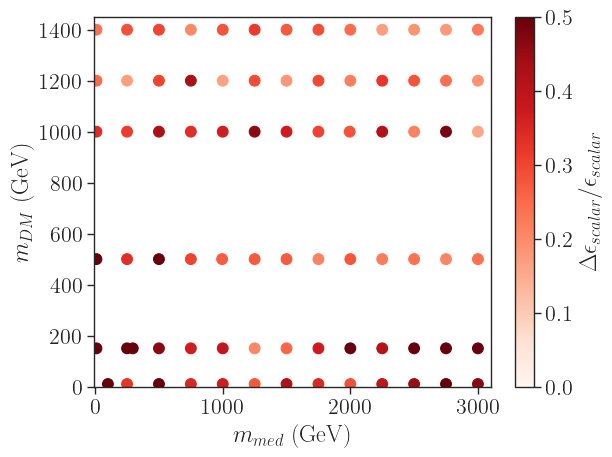

In [31]:
# Plot results
plt.scatter(x=masspts['$m_{med}$'], y=masspts['$m_{DM}$'], vmin=0., vmax=.5, c=maxDiff, 
            cmap=plt.cm.get_cmap('Reds'), s=60)

cbar=plt.colorbar(label=r'$\Delta \epsilon_{scalar}/\epsilon_{scalar}$')
plt.xlabel(r'$m_{med}$ (GeV)')
plt.xlim(-10,3100)
plt.ylabel(r'$m_{DM}$ (GeV)')
plt.ylim(0,1450)
plt.show()

In [27]:
pts = np.array([x for x in product(np.linspace(0.,3000.,100),np.linspace(0.,1500.,100))])
relDiffPts = griddata(list(zip(masspts['$m_{med}$'],masspts['$m_{DM}$'])),
                  maxDiff,pts)
pts = pts[~np.isnan(relDiffPts)]
relDiffPts = relDiffPts[~np.isnan(relDiffPts)]

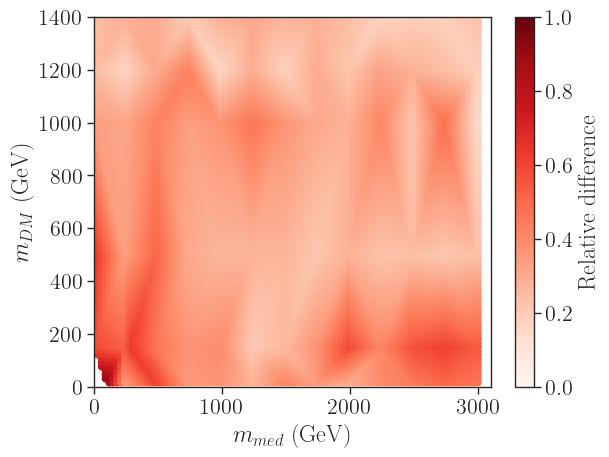

In [28]:
plt.scatter(x=pts[:,0], y=pts[:,1], vmin=0., vmax =1., 
            c=relDiffPts, cmap=plt.cm.get_cmap('Reds'))
cbar = plt.colorbar(label='Relative difference')


plt.xlabel(r'$m_{med}$ (GeV)')
plt.xlim(0,3100)
plt.ylabel(r'$m_{DM}$ (GeV)')
plt.ylim(0,1400)
plt.show()

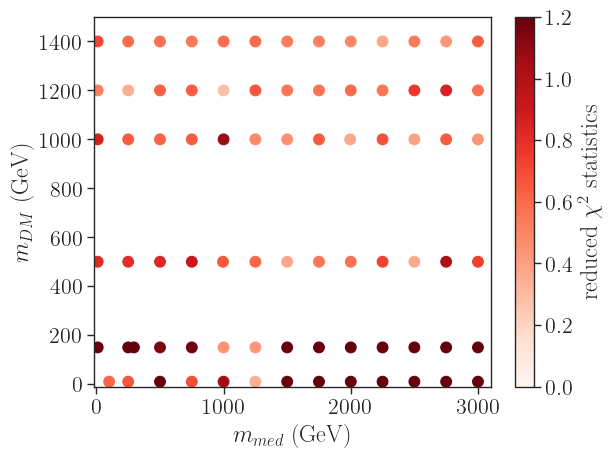

In [22]:
# Plot results
plt.scatter(x=masspts['$m_{med}$'], y=masspts['$m_{DM}$'], vmin=0., vmax=1.2, c=chis, 
            cmap=plt.cm.get_cmap('Reds'), s=60)

cbar=plt.colorbar(label=r'reduced $\chi^{2}$ statistics')
plt.xlabel(r'$m_{med}$ (GeV)')
plt.xlim(-20,3100)
plt.ylabel(r'$m_{DM}$ (GeV)')
plt.ylim(-10,1500)
plt.show()

In [23]:
chisPts = griddata(list(zip(masspts['$m_{med}$'],masspts['$m_{DM}$'])),
                  chis,pts)
ptsChi = pts[~np.isnan(chisPts)]
chisPts = chisPts[~np.isnan(chisPts)]

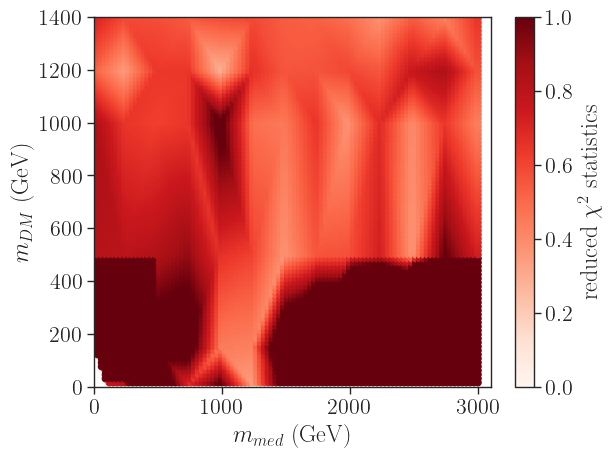

In [24]:
plt.scatter(x=ptsChi[:,0], y=ptsChi[:,1], vmin=0., vmax =1., 
            c=chisPts, cmap=plt.cm.get_cmap('Reds'))
cbar = plt.colorbar(label=r'reduced $\chi^{2}$ statistics')


plt.xlabel(r'$m_{med}$ (GeV)')
plt.xlim(0,3100)
plt.ylabel(r'$m_{DM}$ (GeV)')
plt.ylim(0,1400)
plt.show()

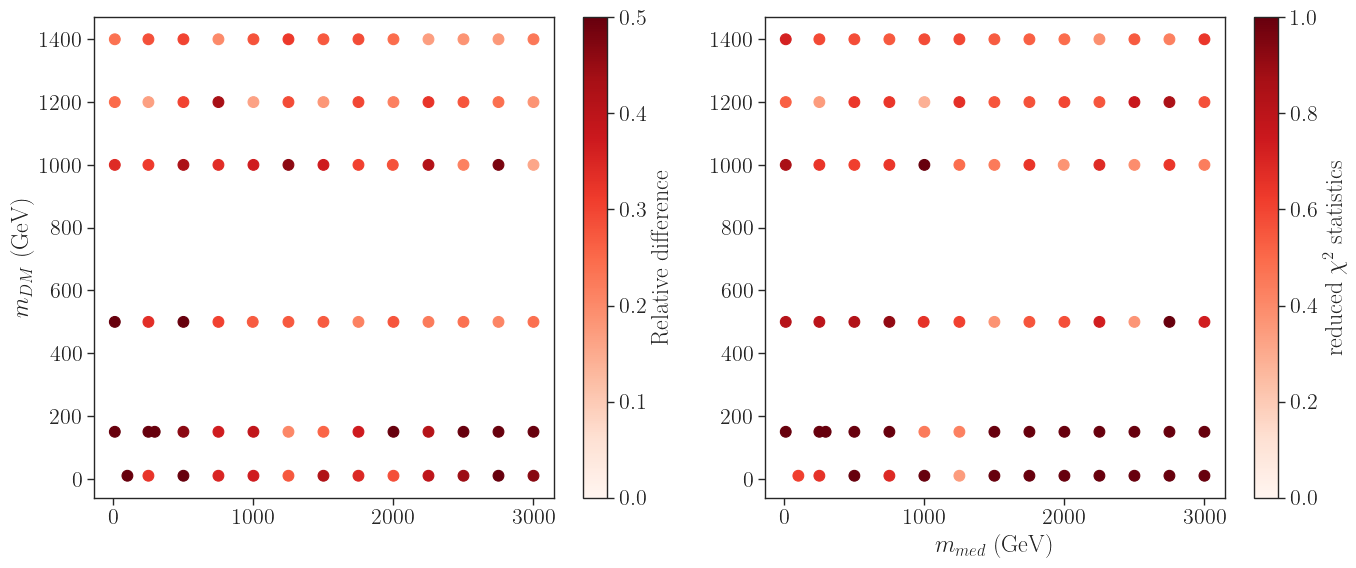

In [35]:
fig,ax = plt.subplots(figsize=(14,6),ncols=2,nrows=1)

p1 = ax[0].scatter(x=masspts['$m_{med}$'], y=masspts['$m_{DM}$'], vmin=0., vmax=.5, c=maxDiff, 
            cmap=plt.cm.get_cmap('Reds'), s=60)

p2 = ax[1].scatter(x=masspts['$m_{med}$'], y=masspts['$m_{DM}$'], vmin=0., vmax=1., c=chis, 
             cmap=plt.cm.get_cmap('Reds'), s=60)

ax[0].set_ylabel(r'$m_{DM}$ (GeV)')
ax[1].set_xlabel(r'$m_{med}$ (GeV)')

cbar1 = plt.colorbar(p1, label='Relative difference', ax=ax[0])
cbar2 = plt.colorbar(p2, label=r'reduced $\chi^{2}$ statistics', ax=ax[1])
plt.tight_layout()
plt.show()

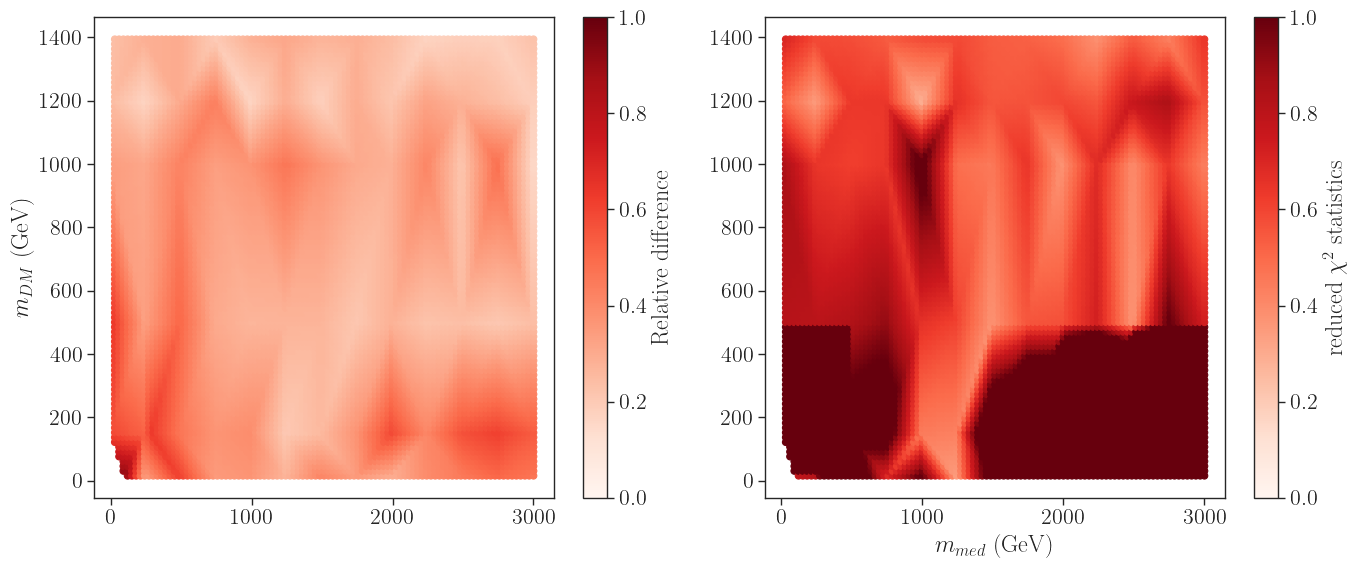

In [34]:
fig,ax = plt.subplots(figsize=(14,6),ncols=2,nrows=1)

p1 = ax[0].scatter(x=pts[:,0], y=pts[:,1], vmin=0., vmax =1., c=relDiffPts, cmap=plt.cm.get_cmap('Reds'))
# ax[0].axline((1, 1), slope=1/2, linestyle='--', color='gray')

p2 = ax[1].scatter(x=ptsChi[:,0], y=ptsChi[:,1], vmin=0., vmax =1., c=chisPts, cmap=plt.cm.get_cmap('Reds'))

ax[0].set_ylabel(r'$m_{DM}$ (GeV)')
ax[1].set_xlabel(r'$m_{med}$ (GeV)')

cbar1 = plt.colorbar(p1, label='Relative difference', ax=ax[0])
cbar2 = plt.colorbar(p2, label=r'reduced $\chi^{2}$ statistics', ax=ax[1])
plt.tight_layout()
plt.show()